In [1]:
## DILATED CONVOLUTION IS ACTIVATED

from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
%matplotlib inline
from PIL import Image
from keras.callbacks import EarlyStopping

from keras.models import *
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, concatenate, Reshape, Permute, Lambda
from keras.activations import softmax
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils import np_utils

/Users/stealth/anaconda/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load image data

In [2]:
im_full_stack = io.imread('unet_train.tif') # 16 slice stack
im_labels2    = io.imread('Labels.tif') # more advanced labels with 2 slices: labels and weights for 3 classes 
im_size = im_labels2.shape[0]

im_labels  = im_labels2[:,:,0:2:] # labels are 0 - backgrounsd, 1 - intermediate region, 2 - MT
im_weights = im_labels2[:,:,1:2:] # weights are 1 for class 11 conflicts, 2 for class 21 or 12 conflicts, 
                            #3 for class 22 conflicts, and 4 for 122 or any other 3-digit (3-object) conflicts
                            # just MTs are 0.5 and labeled background is 0.1

im_nr_frames = im_labels.shape[2]

# swap the dimentions for keras, so the channels are in the end
im_full_stack = np.moveaxis(im_full_stack, 0, 2)

### Visualize images

In [3]:
im_weights.shape

(512, 512, 1)

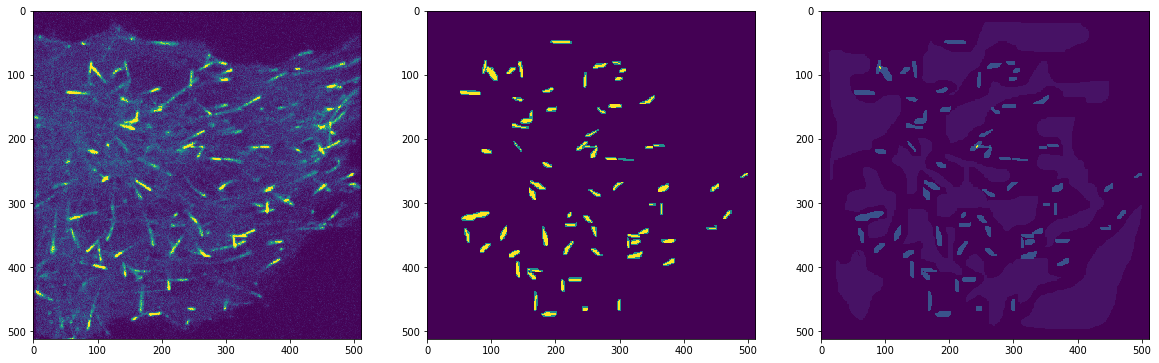

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
ax1.imshow(im_full_stack[:,:,0])
ax2.imshow(im_labels[:,:,0])
ax3.imshow(im_weights[:,:,0])
print()

### Create patches for training 

In [5]:
# randomly generate N patches of size patch_size and select for training only a 
# subset which contains enough pixels with class 1 and 2
N = 100
min_class_size = 10
patch_size = 64

corner_i = np.random.randint(low = 0, high = im_size - patch_size, size = N)
corner_j = np.random.randint(low = 0, high = im_size - patch_size, size = N)
frame_nr = np.random.randint(low = 0, high = im_nr_frames - 1 , size = N)

train_labels = []
train_data = []
train_weights = []

Nreal = 0
for i, j, t in zip (corner_i, corner_j, frame_nr):
        if im_labels[i:i + patch_size, j:j + patch_size, t].sum() > min_class_size:
            
            train_labels.append(im_labels[i:i + patch_size, j:j + patch_size, t])
            train_weights.append(np.exp(2 * im_weights[i:i + patch_size, j:j + patch_size, t])) #exponentiate all the weights
            train_data.append(im_full_stack[i:i + patch_size, j:j + patch_size, t:t+1] / 255) # normalize the data, does not work without
            Nreal += 1

train_labels = np.asarray(train_labels)
train_data   = np.asarray(train_data)
train_weights = np.asarray(train_weights)

# convert labes to categorical values one-hot
n_classes = 3
train_labels = np_utils.to_categorical(train_labels, num_classes = n_classes)
train_labels = train_labels.reshape(Nreal, patch_size, patch_size, n_classes)

train_weights = train_weights.reshape(Nreal, patch_size, patch_size, 1)

train_labels = np.concatenate((train_labels, train_weights), axis = 3)

train_labels = np.asarray(train_labels)

print ('Selected', Nreal, 'patches out of', N)

Selected 76 patches out of 100


### Data augmentation, rotation and flips

In [324]:
train_data90  = np.rot90(train_data, 1, axes =(1, 2))
train_data180 = np.rot90(train_data, 2, axes =(1, 2))
train_data270 = np.rot90(train_data, 3, axes =(1, 2))

train_labels90  = np.rot90(train_labels, 1, axes =(1, 2))
train_labels180 = np.rot90(train_labels, 2, axes =(1, 2))
train_labels270 = np.rot90(train_labels, 3, axes =(1, 2))

train_flip = np.flip(train_data, 1)
train_flip90  = np.rot90(train_flip, 1, axes =(1, 2))
train_flip180 = np.rot90(train_flip, 2, axes =(1, 2))
train_flip270 = np.rot90(train_flip, 3, axes =(1, 2))

train_labels_flip = np.flip(train_labels, 1)
train_labels_flip90  = np.rot90(train_labels_flip, 1, axes =(1, 2))
train_labels_flip180 = np.rot90(train_labels_flip, 2, axes =(1, 2))
train_labels_flip270 = np.rot90(train_labels_flip, 3, axes =(1, 2))

train_data   = np.concatenate((train_data, train_data90, train_data180, train_data270, train_flip, \
                               train_flip90, train_flip180, train_flip270), axis = 0)
train_labels = np.concatenate((train_labels, train_labels90, train_labels180, train_labels270, \
                               train_labels_flip, train_labels_flip90, train_labels_flip180, \
                               train_labels_flip270), axis = 0)

#f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
#ax1.imshow(testim[1,:,:,6])
#ax2.imshow(train_data90[1,:,:,6])
#ax3.imshow(train_labels90[1,:,:,2])
train_data.shape

(600, 64, 64, 1)

### Custom defined loss

In [6]:
def weighted_matrix_loss(y_true, y_pred):
    # in y_true, (None, dimsx, dimsy, 4 channels where three first one are 1-hot-veector for the class and the next one is the weight)
    y_pred_c = K.clip(y_pred, K.epsilon(), 1)
    
    elms = y_true[:,:,:,:3] * K.log(y_pred_c) 
    elms = K.sum(elms, 3) * y_true[:,:,:,3] 
    loss  = -K.mean(elms, (0,1,2))

    return loss

### Unet

In [7]:
inputs = Input((patch_size, patch_size, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate = 2)(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', dilation_rate = 2)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print(conv1.shape)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print(conv2.shape)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print(conv3.shape)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
print(conv4.shape)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
print(conv5.shape)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv11 = Conv2D(n_classes, (1, 1), activation='linear')(conv10)
#print(conv10.shape)

out = Lambda(lambda x: softmax(x, axis = 3))(conv11)

model = Model(inputs=[inputs], outputs=[out])

model.compile(optimizer = 'adam', loss = weighted_matrix_loss, metrics=['accuracy'])

(?, 64, 64, 32)
(?, 32, 32, 64)
(?, 16, 16, 128)
(?, 8, 8, 256)
(?, 4, 4, 512)


In [ ]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, mode = 'auto')
history = model.fit(train_data, train_labels, batch_size=32, epochs=100, verbose=1, shuffle=True,
              validation_split=0.1,
              callbacks=[model_checkpoint, earlystop])

Train on 68 samples, validate on 8 samples
Epoch 1/100
68/68 [==============================] - 8s 111ms/step - loss: 1.2911 - acc: 0.4834 - val_loss: 1.1862 - val_acc: 0.5992
Epoch 2/100
68/68 [==============================] - 6s 90ms/step - loss: 1.1088 - acc: 0.6269 - val_loss: 0.8868 - val_acc: 0.5992
Epoch 3/100
68/68 [==============================] - 7s 104ms/step - loss: 0.9556 - acc: 0.6269 - val_loss: 0.9367 - val_acc: 0.5992
Epoch 4/100
68/68 [==============================] - 7s 96ms/step - loss: 0.9269 - acc: 0.6269 - val_loss: 0.7853 - val_acc: 0.5992
Epoch 5/100
68/68 [==============================] - 5s 80ms/step - loss: 0.8510 - acc: 0.6269 - val_loss: 0.7269 - val_acc: 0.5992
Epoch 6/100
68/68 [==============================] - 6s 85ms/step - loss: 0.7585 - acc: 0.6269 - val_loss: 0.6758 - val_acc: 0.5992
Epoch 7/100
68/68 [==============================] - 6s 94ms/step - loss: 0.6930 - acc: 0.6269 - val_loss: 0.6307 - val_acc: 0.5992
Epoch 8/100
68/68 [============

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


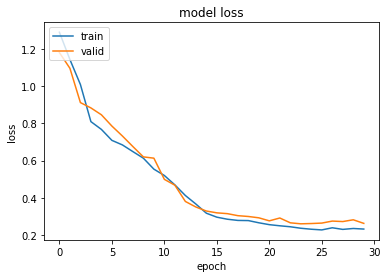

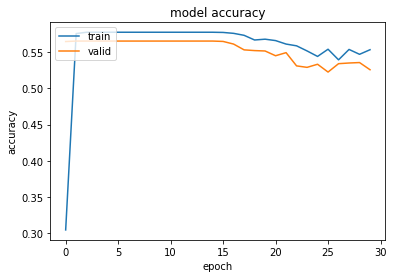

In [338]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()


### apply prediction to the image by patching the whole thing

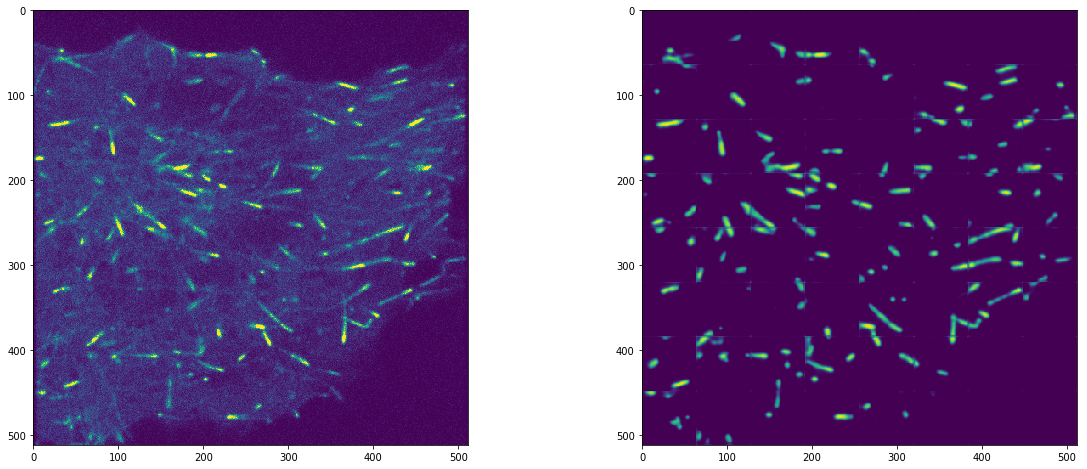

In [339]:
test_image = im_full_stack[:,:,8:9]

# patch the image for the classification 
test_patches = []
nn = im_size // patch_size
for j in range(nn):
    for i in range(nn):
        test_patches.append(test_image[i*patch_size:(i+1) * patch_size, j*patch_size:(j + 1)*patch_size] / 255)

test_patches = np.array(test_patches)
test_patches_res = model.predict(test_patches)
test_patches_res = test_patches_res[:,:,:,2]

test_image_res = np.empty(test_image.shape).astype(np.float)
for j in range(nn):
    for i in range(nn):
        test_image_res[i*patch_size:(i+1)*patch_size,j*patch_size:(j+1)*patch_size, 0] = test_patches_res[i+j*nn]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(test_image[:,:,0])
ax2.imshow(test_image_res[:,:,0])
#print()

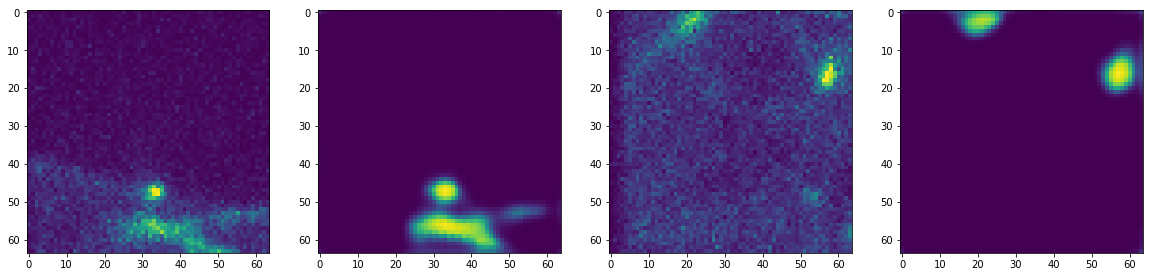

In [341]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(test_patches[0,:,:,0])
ax2.imshow(test_patches_res[0,:,:])
ax3.imshow(test_patches[4,:,:,0])
ax4.imshow(test_patches_res[4,:,:])

### Random patches from the training set

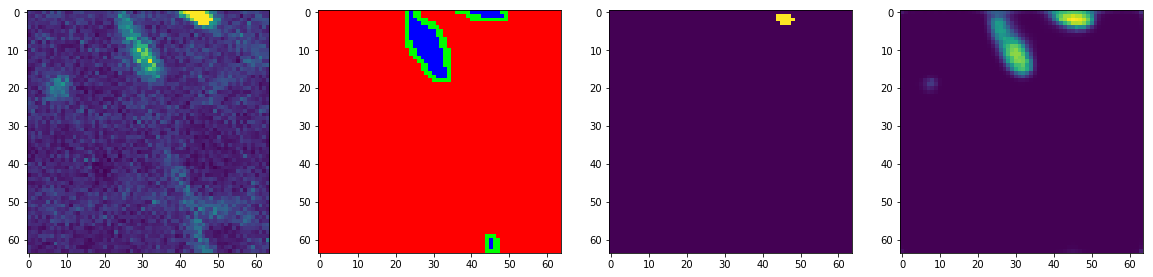

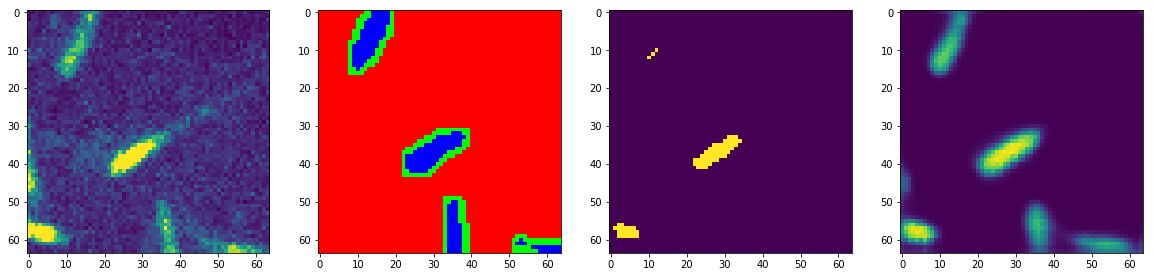

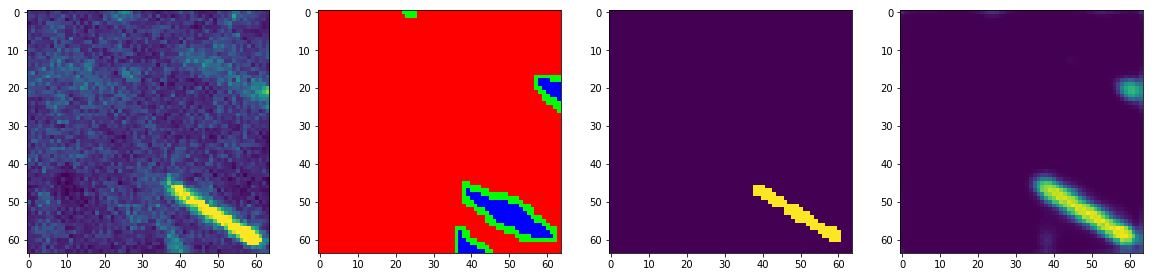

In [342]:
model.load_weights('weights.h5')

im_predict = model.predict(train_data[1:2,:,:, :])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[1,:,:,0])
ax2.imshow(train_labels[1,:,:, :3])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.6] = 1
binarymask[binarymask <0.6] = 0
ax3.imshow(binarymask)


im_predict = model.predict(train_data[5:6,:,:,:])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[5,:,:,0])
ax2.imshow(train_labels[5,:,:, :3])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.6] = 1
binarymask[binarymask <0.6] = 0
ax3.imshow(binarymask)

im_predict = model.predict(train_data[8:9,:,:,:])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[8,:,:,0])
ax2.imshow(train_labels[8,:,:, :3])
ax4.imshow(im_predict[0,:,:,2])

binarymask = im_predict[0,:,:,2]
binarymask[binarymask >=0.6] = 1
binarymask[binarymask <0.6] = 0
ax3.imshow(binarymask)


In [122]:
im = (train_data*65535).astype(np.uint16)

In [124]:
im_big = np.moveaxis(im, 3, 1).reshape(-1,112,112)
from skimage import external
external.tifffile.imsave('patches.tiff',im_big)

In [117]:
# very slow saving but works
imlist = []
for m in im[:100]:
    slice = np.moveaxis(m, 2, 0)
    for k in slice:
        imlist.append(Image.fromarray(k))

imlist[0].save("patches.tif", compression="tiff_deflate", save_all=True, append_images=imlist[1:])

In [99]:
# does not really works, gives only 1 frame in ImageJ
from libtiff import TIFF
tiff = TIFF.open('libtiff.tiff', mode='w')
tiff.write_image(im_big[:1000])
tiff.close()